The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [37]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [38]:
# TODO : import the dataset

# Load the dataset using the correct file path from the uploaded file
file_path = "/content/AB_Test_Results.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)



In [39]:
# TODO : take a quick look at the data

df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Let's see if there are users who have two A/B test groups

In [40]:
# TODO : Look at the distribution of the number of unique groups for each user

# Group by 'USER_ID' and count the number of unique 'VARIANT_NAME' values each user has
unique_group_counts = df.groupby('USER_ID')['VARIANT_NAME'].nunique()

# Display the distribution of the number of unique groups per user
unique_group_distribution = unique_group_counts.value_counts()

# Print the result for easy readability
print("\nDistribution of number of unique groups each user is part of:")
print(unique_group_distribution)


Distribution of number of unique groups each user is part of:
VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64


4783 users belong to only one group (either the control or the variant group).

1541 users belong to two groups (both control and variant).

What Does This Mean?
This indicates that some users were exposed to both versions of the experiment, which can create bias and affect the validity of the A/B test results. It’s generally not recommended for users to be in multiple groups, as it compromises the independence of the test groups.

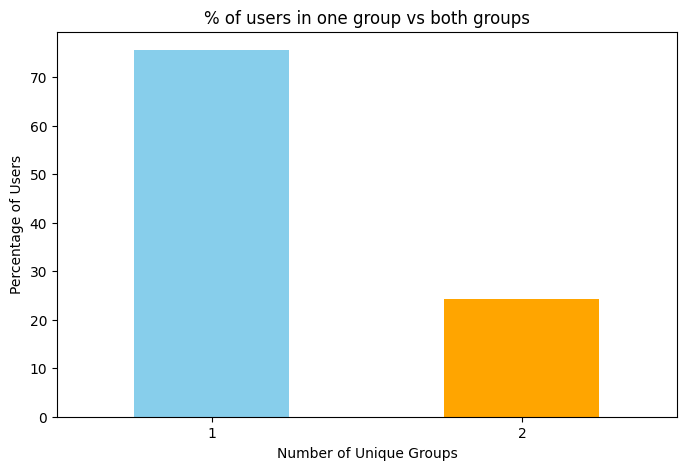

,proportion
VARIANT_NAME,
1,75.632511
2,24.367489


In [41]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms

# MY ADDITION - we want to see what proportion of users fall into one group, and what proportion fall into multiple groups.

# Calculate the distribution of these counts
unique_group_distribution = unique_group_counts.value_counts(normalize=True) * 100  # Convert to percentage

# Visualize the distribution using a bar plot
plt.figure(figsize=(8, 5))
unique_group_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("% of users in one group vs both groups")
plt.xlabel("Number of Unique Groups")
plt.ylabel("Percentage of Users")
plt.xticks(rotation=0)
plt.show()

unique_group_distribution

What can you observe ? Should we exclude these users ? Why ?

Yes exclude them - there is 24% overlap - those people violates the independece of 2 groups and their behavior may be influenced by seeing both versions, leading to biased results.

In [42]:
# TODO : filter the dataset and only keep users
# who are assigned to one A/B test group (either control or variant)
# = remove users participated in both groups

# Step 1: Calculate the number of unique groups for each user
unique_group_counts = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
# Step 2: Filter users who are assigned to only one A/B test group
single_group_users = unique_group_counts[unique_group_counts == 1].index
filtered_df = df[df['USER_ID'].isin(single_group_users)]

filtered_df.nunique()

,0
USER_ID,4783
VARIANT_NAME,2
REVENUE,70


In [43]:
# TODO : Leave only records with users with the 1st ab test group
# TODO : Check that the number of users matches what it was before the exception

# Assuming "control" is the 1st group (adjust if needed based on your data)
first_group = filtered_df['VARIANT_NAME'].unique()[0]  # Get the first unique group name
first_group_df = filtered_df[filtered_df['VARIANT_NAME'] == first_group]

# Step 4: Check if the number of users matches the expected value before excluding other groups
final_user_count = first_group_df['USER_ID'].nunique()

print(f"Number of users in the first group after filtering: {final_user_count}")

Number of users in the first group after filtering: 2393


Let's see how the data is distributed

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


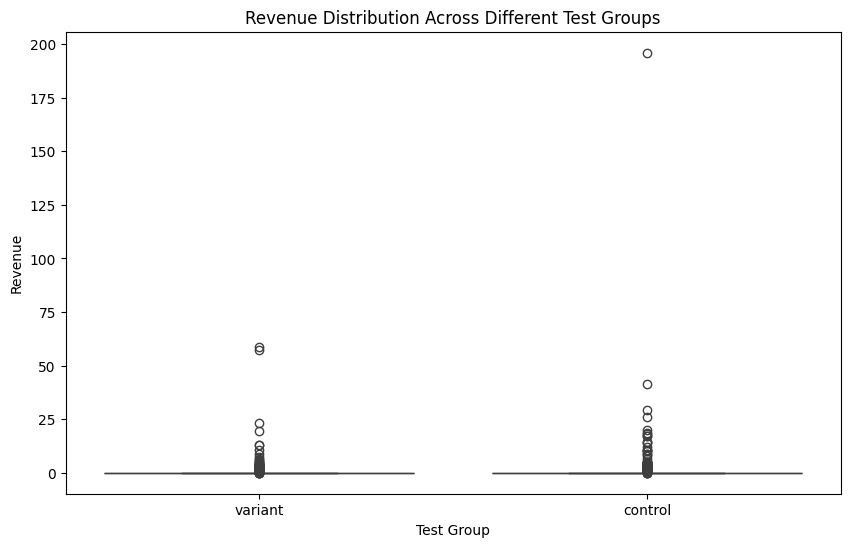

In [44]:
# TODO : Check how the data is distributed using a box plot

plt.figure(figsize=(10, 6))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.title('Revenue Distribution Across Different Test Groups')
plt.xlabel('Test Group')
plt.ylabel('Revenue')
plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [45]:
# TODO : Sort these revenue values in descending order

sorted_revenue = df.sort_values(by='REVENUE', ascending=False)
sorted_revenue.head(10)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
6447,2881,variant,58.63
7642,7206,variant,57.46
9421,6792,control,41.53
8168,2166,control,29.32
9125,831,control,25.98
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56


In [46]:
# TODO : See if user with ID 3342 had other events with a strong outlier

# I don't understand this task - this user only has one value for revenue, what other outliers could he have?

We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

<ipython-input-47-9e8a5a105090>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=filtered_df, palette='Set2')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to ge

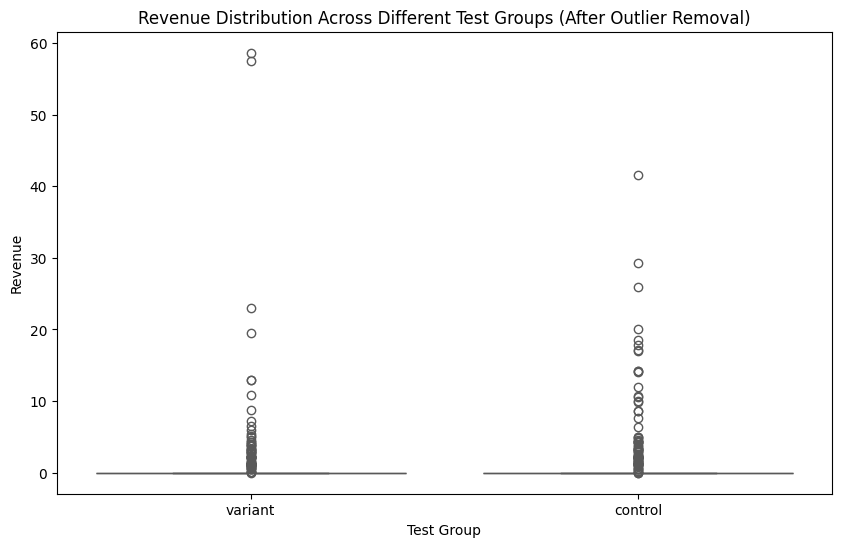

In [47]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.

# Creates a new DataFrame excluding all rows where USER_ID is 3342.
filtered_df = df[df['USER_ID'] != 3342]

plt.figure(figsize=(10, 6))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=filtered_df, palette='Set2')
plt.title('Revenue Distribution Across Different Test Groups (After Outlier Removal)')
plt.xlabel('Test Group')
plt.ylabel('Revenue')
plt.show()


What can you say about the users and their purchases ?

In [48]:
# TODO : Check if there are users who have records with zero and positive revenue

# Step 1: Group by 'USER_ID' and check if users have both zero and positive revenue values
mixed_revenue_users = df.groupby('USER_ID')['REVENUE'].apply(lambda x: (0 in x.values) and (x.max() > 0))

# Step 2: Filter the users who have both zero and positive revenue values
users_with_mixed_revenue = mixed_revenue_users[mixed_revenue_users].index

# Step 3: Display the list of these users
print(f"Users with both zero and positive revenue records: {list(users_with_mixed_revenue)}")

# Step 4: Display the count of these users
print(f"Number of users with both zero and positive revenue: {len(users_with_mixed_revenue)}")

Users with both zero and positive revenue records: [124, 169, 282, 403, 443, 487, 618, 701, 702, 708, 828, 831, 839, 868, 1035, 1053, 1106, 1252, 1254, 1339, 1883, 1939, 2166, 2181, 2182, 2252, 2364, 2489, 2529, 2767, 2881, 3028, 3198, 3326, 3331, 3566, 3699, 3797, 4113, 4209, 4724, 4858, 4870, 4918, 5046, 5053, 5134, 5205, 5270, 5461, 5597, 5769, 5845, 5900, 6207, 6214, 6271, 6391, 6429, 6430, 6492, 6497, 6614, 6678, 6792, 7206, 7238, 7358, 7613, 7915, 7930, 8020, 8175, 8471, 8479, 8536, 8583, 8700, 8863, 8886, 8920, 8927, 8984, 9150, 9526, 9661, 9669, 9766, 9928, 9942, 9996]
Number of users with both zero and positive revenue: 91


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [49]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
# My explanation of the task: group the data by each user (USER_ID) and sum up the total revenue for each user, resulting in a single record per user. This is based on the assumption that each record currently represents a user’s visit to the service (e.g., viewing the website or making a purchase), but the experimental unit we want to analyze is at the user level rather than the visit level.

#After this aggregation, we will have a new dataset where each row corresponds to a single user with their total revenue value.
# This makes it easier to perform user-level comparisons between test groups.

#vGroup by 'USER_ID' and sum the 'REVENUE' for each user
user_level_data = df.groupby('USER_ID').agg(
    total_revenue=('REVENUE', 'sum'),   # Sum up the revenue for each user
    variant_group=('VARIANT_NAME', 'first')  # Keep the group each user belongs to (assuming no duplicates)
).reset_index()

user_level_data.head()

,USER_ID,total_revenue,variant_group
0,2,0.0,control
1,3,0.0,variant
2,4,0.0,variant
3,5,0.0,variant
4,6,0.0,variant


<ipython-input-50-e5d64d32427c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='variant_group', y='total_revenue', data=user_level_data, palette='Set2')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 

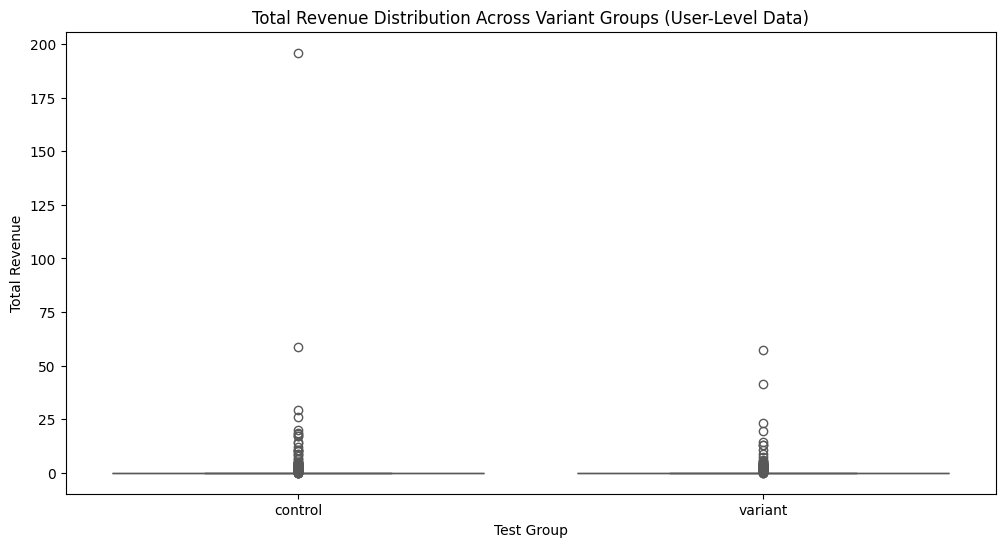

In [50]:
# TODO : Visualize the resulting distribution of the data again.

plt.figure(figsize=(12, 6))
sns.boxplot(x='variant_group', y='total_revenue', data=user_level_data, palette='Set2')
plt.title('Total Revenue Distribution Across Variant Groups (User-Level Data)')
plt.xlabel('Test Group')
plt.ylabel('Total Revenue')
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [51]:
# Step 1: Aggregate user-level data again to get total revenue per user
user_level_data = df.groupby('USER_ID').agg(
    total_revenue=('REVENUE', 'sum'),
    variant_group=('VARIANT_NAME', 'first')
).reset_index()

# Step 2: Calculate basic metrics for each variant group
group_metrics = user_level_data.groupby('variant_group')['total_revenue'].agg(
    mean_revenue='mean',
    median_revenue='median',
    sum_revenue='sum',
    user_count='count'
).reset_index()

# Step 3: Print the group metrics to confirm
print("Group Metrics DataFrame:")
print(group_metrics)

# Step 4: Use the correct group names: 'control' and 'variant'
control_metrics = group_metrics[group_metrics['variant_group'] == 'control'].iloc[0]
variant_metrics = group_metrics[group_metrics['variant_group'] == 'variant'].iloc[0]

# Step 5: Calculate percentage changes between control and variant groups
relative_mean_change = ((variant_metrics['mean_revenue'] - control_metrics['mean_revenue']) / control_metrics['mean_revenue']) * 100
relative_median_change = ((variant_metrics['median_revenue'] - control_metrics['median_revenue']) / control_metrics['median_revenue']) * 100

# Step 6: Create a separate DataFrame for relative metrics
relative_metrics = pd.DataFrame({
    'metric': ['relative_mean_change', 'relative_median_change'],
    'value': [relative_mean_change, relative_median_change]
})

# Display the main group metrics and relative metrics
print("\nMetrics by Group:")
print(group_metrics)

print("\nRelative Metrics between Control and Variant Groups:")
print(relative_metrics)

Group Metrics DataFrame:
  variant_group  mean_revenue  median_revenue  sum_revenue  user_count
0       control      0.207340             0.0       649.39        3132
1       variant      0.108108             0.0       345.08        3192

Metrics by Group:
  variant_group  mean_revenue  median_revenue  sum_revenue  user_count
0       control      0.207340             0.0       649.39        3132
1       variant      0.108108             0.0       345.08        3192

Relative Metrics between Control and Variant Groups:
                   metric      value
0    relative_mean_change -47.859755
1  relative_median_change        NaN


<ipython-input-51-3c578f38b290>:25: RuntimeWarning: invalid value encountered in scalar divide
  relative_median_change = ((variant_metrics['median_revenue'] - control_metrics['median_revenue']) / control_metrics['median_revenue']) * 100


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

ME added:
This analysis helps to understand if the variant group is impacting paying users in a different way compared to the overall user base.
If there’s a drop in mean revenue or median revenue for paying users in the variant group, it’s a strong signal that the test variant is negatively affecting high-value users.

In [53]:
# TODO : get metrics by groups
# TODO : create two additional metrics to see relative changes
# TODO : add them to the rest of the metrics in a separate group

# Step 1: Filter to keep only paying users (users with REVENUE > 0)
paying_users_df = df[df['REVENUE'] > 0]

# Step 2: Aggregate user-level data for paying users
user_level_paying_data = paying_users_df.groupby('USER_ID').agg(
    total_revenue=('REVENUE', 'sum'),
    variant_group=('VARIANT_NAME', 'first')
).reset_index()

# Step 3: Calculate metrics for each group
paying_group_metrics = user_level_paying_data.groupby('variant_group')['total_revenue'].agg(
    mean_revenue='mean',
    median_revenue='median',
    sum_revenue='sum',
    user_count='count'
).reset_index()

# Step 4: Display the paying group metrics
print("Paying Group Metrics DataFrame:")
print(paying_group_metrics)

# Step 5: Calculate relative metrics for paying users
control_paying_metrics = paying_group_metrics[paying_group_metrics['variant_group'] == 'control'].iloc[0]
variant_paying_metrics = paying_group_metrics[paying_group_metrics['variant_group'] == 'variant'].iloc[0]

# Calculate percentage changes between control and variant for paying users
relative_mean_change_paying = ((variant_paying_metrics['mean_revenue'] - control_paying_metrics['mean_revenue']) / control_paying_metrics['mean_revenue']) * 100
relative_median_change_paying = ((variant_paying_metrics['median_revenue'] - control_paying_metrics['median_revenue']) / control_paying_metrics['median_revenue']) * 100

# Step 6: Create a DataFrame to store the relative changes for paying users
relative_paying_metrics = pd.DataFrame({
    'metric': ['relative_mean_change_paying', 'relative_median_change_paying'],
    'value': [relative_mean_change_paying, relative_median_change_paying]
})

# Step 7: Display the final metrics
print("\nMetrics for Paying Users by Group:")
print(paying_group_metrics)

print("\nRelative Metrics between Control and Variant Groups for Paying Users:")
print(relative_paying_metrics)


Paying Group Metrics DataFrame:
  variant_group  mean_revenue  median_revenue  sum_revenue  user_count
0       control      8.123291            2.99       641.74          79
1       variant      4.968028            2.27       352.73          71

Metrics for Paying Users by Group:
  variant_group  mean_revenue  median_revenue  sum_revenue  user_count
0       control      8.123291            2.99       641.74          79
1       variant      4.968028            2.27       352.73          71

Relative Metrics between Control and Variant Groups for Paying Users:
                          metric      value
0    relative_mean_change_paying -38.842175
1  relative_median_change_paying -24.080268


Let's look at the distributions of all and only paying users

<ipython-input-54-6823f3e6b917>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
<ipython-input-54-6823f3e6b917>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'],

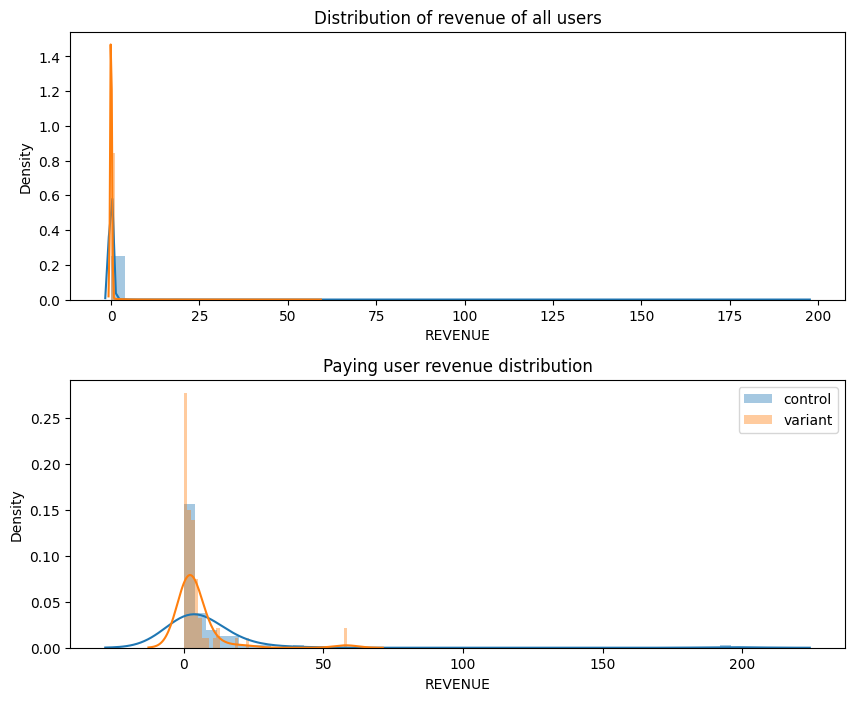

In [54]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [55]:
# TODO : Use the Shapiro-Wilk criterion to confirm it


# Step 1: Filter only paying users (REVENUE > 0)
paying_users_df = df[df['REVENUE'] > 0]

# Step 2: Separate revenue values by group
control_revenue = paying_users_df[paying_users_df['VARIANT_NAME'] == 'control']['REVENUE']
variant_revenue = paying_users_df[paying_users_df['VARIANT_NAME'] == 'variant']['REVENUE']

# Step 3: Apply the Shapiro-Wilk test for normality for both groups
control_stat, control_p_value = shapiro(control_revenue)
variant_stat, variant_p_value = shapiro(variant_revenue)

# Step 4: Display the results
print(f"Shapiro-Wilk Test for Control Group: W-Statistic = {control_stat:.4f}, p-value = {control_p_value:.4f}")
print(f"Shapiro-Wilk Test for Variant Group: W-Statistic = {variant_stat:.4f}, p-value = {variant_p_value:.4f}")

# Step 5: Interpret the results
if control_p_value < 0.05:
    print("The control group revenue distribution is NOT normal (reject H0).")
else:
    print("The control group revenue distribution is normal (fail to reject H0).")

if variant_p_value < 0.05:
    print("The variant group revenue distribution is NOT normal (reject H0).")
else:
    print("The variant group revenue distribution is normal (fail to reject H0).")

Shapiro-Wilk Test for Control Group: W-Statistic = 0.2808, p-value = 0.0000
Shapiro-Wilk Test for Variant Group: W-Statistic = 0.4171, p-value = 0.0000
The control group revenue distribution is NOT normal (reject H0).
The variant group revenue distribution is NOT normal (reject H0).


Is the null hypothesis about the normal distribution of the data rejected ?

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

ME ADDED

Why Use the Mann-Whitney U Test?
Non-Normal Data: Based on the Shapiro-Wilk test results, we confirmed that the data is not normally distributed. This makes the Mann-Whitney U test (a non-parametric test) more appropriate than a t-test, which assumes normality.

Checking for Differences: The Mann-Whitney U test compares the medians of two groups to see if they are significantly different. It is useful when we have skewed distributions or outliers, as it doesn’t require the same assumptions as parametric tests.

Handling Zero Values and Duplicates: The comment mentions that duplicate values and zero revenue values are common in the dataset. The Mann-Whitney test can handle ties and duplicates but requires careful interpretation when there are many zero values. Zero values might distort the results because they represent non-paying users or users without revenue.

In [ ]:
(df['REVENUE'] == 0).value_counts()

In [56]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test

# Step 1: Separate the revenue values for control and variant groups
control_revenue = df[df['VARIANT_NAME'] == 'control']['REVENUE']
variant_revenue = df[df['VARIANT_NAME'] == 'variant']['REVENUE']

# Step 2: Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(control_revenue, variant_revenue, alternative='two-sided')

# Step 3: Display the results
print(f"Mann-Whitney U Test Statistic: {stat:.4f}, p-value: {p_value:.4f}")

# Step 4: Interpret the results
if p_value < 0.05:
    print("The difference in revenue distribution between control and variant groups is statistically significant (reject H0).")
else:
    print("The difference in revenue distribution between control and variant groups is not statistically significant (fail to reject H0).")

Mann-Whitney U Test Statistic: 12521564.0000, p-value: 0.4783
The difference in revenue distribution between control and variant groups is not statistically significant (fail to reject H0).


In [ ]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test

In [58]:
# Step 1: Filter only paying users (REVENUE > 0)
paying_users_df = df[df['REVENUE'] > 0]

# Step 2: Separate the revenue values for control and variant groups
control_revenue_paying = paying_users_df[paying_users_df['VARIANT_NAME'] == 'control']['REVENUE']
variant_revenue_paying = paying_users_df[paying_users_df['VARIANT_NAME'] == 'variant']['REVENUE']

# Step 3: Perform the Mann-Whitney U test for paying users
stat_paying, p_value_paying = mannwhitneyu(control_revenue_paying, variant_revenue_paying, alternative='two-sided')

# Step 4: Display the results for paying users
print(f"Mann-Whitney U Test for Paying Users: Statistic = {stat_paying:.4f}, p-value = {p_value_paying:.4f}")

# Step 5: Interpret the results
if p_value_paying < 0.05:
    print("The difference in revenue distribution between control and variant groups (for paying users) is statistically significant (reject H0).")
else:
    print("The difference in revenue distribution between control and variant groups (for paying users) is not statistically significant (fail to reject H0).")

Mann-Whitney U Test for Paying Users: Statistic = 3356.0000, p-value = 0.0792
The difference in revenue distribution between control and variant groups (for paying users) is not statistically significant (fail to reject H0).


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [ ]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
# TODO : Generate samples for all users

In [ ]:
# TODO : Generate samples for only paying users

Let's look at the distribution of means in the ab test groups

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1),
                                     np.mean(control, axis=1),
                                     title='all users')

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1),
                                     np.mean(control_paid, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.
